In [1]:
# Modules will be reloaded every time a cell is executed
%load_ext autoreload
%autoreload 2

In [29]:
import pandas as pd
import numpy as np
from Bio.Seq import Seq

from utils.data_processing import parse_biomart_fasta

In [3]:
IN_UTR_SEQ_TXT_PATH = 'data/GRCh37.p13 hg19/utr_sequences_hg19.txt'
MIRNA_FCS = 'data/fold_change/mirna_fcs.csv'
TS_GENE_INFO = 'data/target_scan_8/Gene_info.txt'
ID_MAP = 'data/GRCh37.p13 hg19/UCSC/id_map'

OUT_UTR_DF_MIRNA_FC_PATH = 'data/processed/GRCh37.p13 hg19/3utr.sequences.refseq_id.mirna_fc.pkl'

In [4]:
SEQUENCE_UNAVAILABLE = Seq("Sequenceunavailable")

In [5]:
utrs = parse_biomart_fasta(IN_UTR_SEQ_TXT_PATH)

In [6]:
utrs_df = pd.DataFrame(utrs)
utrs_with_seq = utrs_df[utrs_df.sequence != SEQUENCE_UNAVAILABLE]

In [7]:
mirna_fc = pd.read_csv(MIRNA_FCS)
mirna_fc['RefSeq ID'].nunique()

8372

In [8]:
ucsc_id_map = pd.read_csv(ID_MAP, comment='#', header=None, names=[
    "knownGene.name",
    "knownGene.chrom",
    "kgAlias.kgID",
    "kgAlias.alias",
    "kgXref.kgID",
    "kgXref.mRNA",
    "kgXref.geneSymbol",
    "kgXref.refseq",
    "knownToEnsembl.name",
    "knownToEnsembl.value",
    "knownToRefSeq.name",
    "knownToRefSeq.value"
], delimiter='\t')

In [9]:
ucsc_id_map['RefSeq ID'] = ucsc_id_map['knownToRefSeq.value'].fillna(
    ucsc_id_map['kgXref.refseq']
)

In [10]:
ucsc_id_map = ucsc_id_map[
    [
        'knownGene.chrom',
        'knownToEnsembl.value',
        'RefSeq ID',
        'kgXref.geneSymbol',
    ]
]

In [11]:
mirnas = ['hsa-miR-16-5p', 'hsa-miR-106b-5p',
       'hsa-miR-200a-3p', 'hsa-miR-200b-3p', 'hsa-miR-215-5p', 'hsa-let-7c-5p',
       'hsa-miR-103a-3p']

In [12]:
ts_gene_info = pd.read_csv(TS_GENE_INFO, sep='\t')

In [13]:
ts_gene_info = ts_gene_info[['Transcript ID', 'Representative transcript?']]

In [14]:
mirna_fc_ucsc_id = pd.merge(
    mirna_fc,
    ucsc_id_map,
    left_on='RefSeq ID',
    right_on='RefSeq ID',
    how='left',
)
mirna_fc_ucsc_id = mirna_fc_ucsc_id.drop_duplicates()

print(mirna_fc['RefSeq ID'].nunique(), mirna_fc_ucsc_id['RefSeq ID'].nunique(), mirna_fc_ucsc_id.shape)

8372 8372 (13078, 12)


### Join UTR sequences mirna_fc_ucsc_id FC with RefSeq and Ensemble IDs

In [15]:
mirna_fc_ucsc_id_seq = pd.merge(
    mirna_fc_ucsc_id,
    utrs_with_seq,
    left_on='knownToEnsembl.value',
    right_on='ensembl_transcript_id',
    how='left',
)
mirna_fc_ucsc_id_seq = mirna_fc_ucsc_id_seq.drop(columns=['ensembl_transcript_id'])
print(mirna_fc_ucsc_id_seq['RefSeq ID'].nunique())

8372


In [16]:
mirna_fc_ucsc_id_seq_repre = pd.merge(
    mirna_fc_ucsc_id_seq,
    ts_gene_info,
    left_on = 'ensembl_transcript_id_version',
    right_on = 'Transcript ID',
    how = 'left',
)
print(mirna_fc_ucsc_id_seq_repre['RefSeq ID'].nunique())

8372


In [17]:
utrs_with_seq_repre = pd.merge(
    utrs_with_seq,
    ts_gene_info,
    left_on = 'ensembl_transcript_id_version',
    right_on = 'Transcript ID',
    how = 'left',
)
print(mirna_fc_ucsc_id_seq_repre['RefSeq ID'].nunique())

8372


### Keep representative/longest_UTR per RefSeq ID

In [18]:
mirna_fc_ucsc_id_seq_repre["sequence_origin"] = None

In [19]:
def get_seq_len(a):
    if a is None or a == '' or pd.isna(a):
        return 0
    else:
        return len(a)
    
def has_sequence(index, df):
    return pd.notnull(index) and get_seq_len(df.iloc[index].sequence) > 0

utrs_longest_seq = []
refseq_id_not_resolved = []

groupby_refseq = mirna_fc_ucsc_id_seq_repre.groupby("RefSeq ID")
groupby_gene = utrs_with_seq_repre.groupby('external_gene_name')
groupby_ensembl_id = utrs_with_seq_repre.groupby('ensembl_transcript_id_version')

for group_name, group in groupby_refseq:
    repre_index_per_gene = None
    longest_utr_index_per_gene = None
    repre_index_per_ensembl_id = None
    longest_utr_index_per_ensembl_id = None
    
    repre_transcript_index = group['Representative transcript?'].idxmax()
    longest_utr_index = group.sequence.map(lambda a: get_seq_len(a)).idxmax()
    longest_transcript_index = pd.to_numeric(group['transcript_length']).idxmax()

    genes_of_refseq_id = list(set(group['Gene symbol']))
    ensembl_ids_of_refseq_id = list(set(group['ensembl_transcript_id_version']))
                                    
    for gene in genes_of_refseq_id:
        if pd.notnull(gene) and gene in groupby_gene.groups.keys():
            group_of_gene_symbol = groupby_gene.get_group(gene)
            repre_index_per_gene = group_of_gene_symbol['Representative transcript?'].idxmax()
            longest_utr_index_per_gene = group_of_gene_symbol.sequence.map(lambda a: get_seq_len(a)).idxmax()
    
    for ensembl_id in ensembl_ids_of_refseq_id:
        if pd.notnull(ensembl_id) and ensembl_id in groupby_ensembl_id.groups.keys():
            group_of_ensembl_id = groupby_ensembl_id.get_group(ensembl_id)
            repre_index_per_ensembl_id = group_of_ensembl_id['Representative transcript?'].idxmax()
            longest_utr_index_per_ensembl_id = group_of_ensembl_id.sequence.map(lambda a: get_seq_len(a)).idxmax()
    
    indexes = {
        'repre_transcript': {
            'index':repre_transcript_index,
            'is_original_sequence':True,
            'dataframe': mirna_fc_ucsc_id_seq_repre,
        },
        'longest_utr': {
            'index':longest_utr_index,
            'is_original_sequence':True,
            'dataframe': mirna_fc_ucsc_id_seq_repre,
        },
        'repre_per_ensembl_id': {
            'index':repre_index_per_ensembl_id,
            'is_original_sequence':False,
            'dataframe':utrs_with_seq_repre
        },
        'longest_utr_per_ensembl_id': {
            'index':longest_utr_index_per_ensembl_id,
            'is_original_sequence':False,
            'dataframe':utrs_with_seq_repre
        },
        'repre_per_gene': {
            'index':repre_index_per_gene,
            'is_original_sequence':False,
            'dataframe':utrs_with_seq_repre
        },
        'longest_utr_per_gene': {
            'index':longest_utr_index_per_gene,
            'is_original_sequence':False,
            'dataframe':utrs_with_seq_repre
        },
    }
    for name, index in indexes.items():
        if has_sequence(index['index'], index['dataframe']):
            selected_sequence_row = index['dataframe'].iloc[index['index']]
            if index['is_original_sequence']:
                selected_sequence_row["sequence_origin"] = 'RefSeq ID'
                utrs_longest_seq.append(selected_sequence_row)  
            elif pd.isnull(longest_transcript_index):
                if group.shape[0] == 1:
                    original_row = group.iloc[0].copy()
                    original_row['sequence'] = selected_sequence_row['sequence']
                    if 'gene' in name:
                        original_row["sequence_origin"] = 'Gene symbol'
                    else:
                        original_row["sequence_origin"] = 'ensembl_transcript_id_version'
                    utrs_longest_seq.append(original_row)
            else:
                original_row = mirna_fc_ucsc_id_seq_repre.iloc[longest_transcript_index]
                original_row['sequence'] = selected_sequence_row['sequence']
                utrs_longest_seq.append(original_row)
            break
    else:
        refseq_id_not_resolved.append(group_name)
        
utrs_selected_seq_df = pd.DataFrame(utrs_longest_seq)

print(utrs_selected_seq_df['RefSeq ID'].nunique(), utrs_selected_seq_df.shape)

/tmp/ipykernel_1460/591865410.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_sequence_row["sequence_origin"] = 'RefSeq ID'


8325 (8325, 29)


In [20]:
print(
    len(refseq_id_not_resolved),
    len(set(refseq_id_not_resolved))
)

32 32


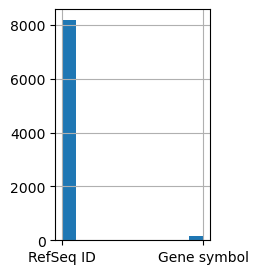

In [21]:
utrs_selected_seq_df.sequence_origin.hist(figsize=(2,3))

In [22]:
groupby_refseq.size(), groupby_refseq['RefSeq ID'].nunique()

(RefSeq ID
 NM_000017    2
 NM_000019    3
 NM_000021    3
 NM_000023    2
 NM_000027    1
             ..
 NM_213646    1
 NM_213647    1
 NM_213649    1
 NM_213651    1
 NM_213662    1
 Length: 8372, dtype: int64,
 RefSeq ID
 NM_000017    1
 NM_000019    1
 NM_000021    1
 NM_000023    1
 NM_000027    1
             ..
 NM_213646    1
 NM_213647    1
 NM_213649    1
 NM_213651    1
 NM_213662    1
 Name: RefSeq ID, Length: 8372, dtype: int64)

In [23]:
missing_sequences = utrs_selected_seq_df[utrs_selected_seq_df.sequence.isna()]['RefSeq ID'].values

In [24]:
utrs_selected_seq_df[utrs_selected_seq_df['RefSeq ID'].isin(missing_sequences)].to_csv('missing_sequences.csv')

In [25]:
utrs_selected_seq_df.sequence.isna().sum()

0

### Do sequences repeat?

(8325, 29)


1    8305
2      10
Name: count, dtype: int64

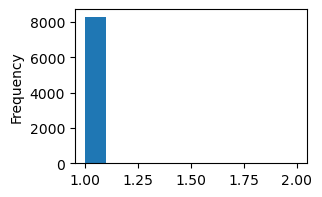

In [26]:
groupby_sequence = utrs_selected_seq_df.groupby('sequence')
print(utrs_selected_seq_df.shape)

groupby_sequence.size().plot(kind = "hist", figsize=(3,2))
groupby_sequence.size().value_counts()

In [27]:
utrs_selected_seq_df.to_pickle(OUT_UTR_DF_MIRNA_FC_PATH)